In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random 

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pickle
import time
import seaborn

import pandas as pd

from PIL import Image

%matplotlib inline

### Prepare Datasets

In [2]:
brands = {"LV":["alma", "neverfull", "newwavechaintote", "petiteboitechapeau", "speedy"],
         "Chanel":["2.55_classicdoubleflapbag", "boy", "grandshoppingtote"],
         "Gucci":["dionysus", "ggmarmont", "sohodisco", "sylvie"],
         "MK":["jetsettote", "mercertotebag", "selmasatchel"],
         "LP":["classic"],
         "Coach":["F57842"],
         "other":["other"],
         "other_bag":["bag"]}

In [3]:
def check_path(path):
    if not os.path.exists(path):
        os.system("mkdir " + path)

In [4]:
def copy_data(data_list, label, path, copy_type="brands"):
    path = os.path.join(path, label)
    check_path(path)
    if copy_type == "brands":
        for i in data_list:
            os.system("cp " + i + " " + path + "/" + i.split("/")[-2] + "_" + i.split("/")[-1].split(".")[0] + ".jpg")
    elif copy_type == "name":
        for i in data_list:
            os.system("cp " + i + " " + path)
        

In [5]:
def train_validation_split(inpath, outpath, split_type="brands", random_seed = 1):
    train_path = os.path.join(outpath, "train")
    val_path = os.path.join(outpath, "val")
    test_path = os.path.join(outpath, "test")
    check_path(train_path)
    check_path(val_path)
    check_path(test_path)
    random.seed(random_seed)
    train_num = 0 
    test_num = 0 
    val_num = 0 
    if split_type == "brands":
        for key in brands:
            for kk in brands[key]:
                images = [os.path.join(os.path.join(inpath, key + "/" + kk), i) for i in os.listdir(os.path.join(inpath, key + "/" + kk)) if i.split(".")[1] == "jpg"]
                train = random.sample(images, int(len(images) * 0.8))
                train_num += len(train)
                val_test = [i for i in images if i not in train]
                val = random.sample(val_test, int(len(val_test) * 0.5))
                val_num += len(val)
                test = [i for i in val_test if i not in val]
                test_num += len(test)
                copy_data(train, key, train_path)
                copy_data(val, key, val_path)
                copy_data(test, key, test_path)
            print(train_num)
        print(train_num, test_num, val_num)
    elif split_type == "name":
        for key in brands:
            for kk in brands[key]:
                images = [os.path.join(os.path.join(inpath, key + "/" + kk), i) for i in os.listdir(os.path.join(inpath, key + "/" + kk)) if i.split(".")[1] == "jpg"]
                train = random.sample(images, int(len(images) * 0.8))
                val_test = [i for i in images if i not in train]
                val = random.sample(val_test, int(len(val_test) * 0.5))
                test = [i for i in val_test if i not in val]
                copy_data(train, kk, train_path, copy_type="name")
                copy_data(val, kk, val_path, copy_type="name")
                copy_data(test, kk, test_path, copy_type="name")

In [8]:
inpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed"
outpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/processed/brands_correct"
train_validation_split(inpath, outpath, split_type="brands", random_seed = 1)

672
1255
1741
2098
2295
2483
2883
3268
3268 417 408


In [103]:
inpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed"
outpath = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/processed/name_correct_merged"
train_validation_split(inpath, outpath, split_type="name", random_seed = 1)

In [182]:
def prepare_other_bag(path, out_path):
    images = [i for i in os.listdir(path)]
    images_use = random.sample(images, 500)
    for i in images_use:
        print("cp " + path + i.split()[0] + "\ " + i.split()[1] + " " + out_path)
        os.system("cp " + path +  i.split()[0] + "\ " + i.split()[1] + " " + out_path)
def prepare_others(path, out_path):
    images = [str(i) + ".jpg" for i in range(2300) if str(i) + ".jpg" not in os.listdir("/Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other")]
    images_use = random.sample(images, 500)
    for i in images_use:
        os.system("cp " + os.path.join(path,i) + " " + out_path)

In [181]:
path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/"
out_path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag"
prepare_other_bag(path, out_path)

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ business_1.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ tossed_35.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/leather\ handbag_12.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/expensive\ handbag_25.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/crocodile\ handbag_14.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ tossed_28.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/green\ handbag_29.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ clutching_32.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ opening_5.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/alligator\ handbag_8.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/pair\ handbag_28.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/cloth\ handbag_29.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/b

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/prada\ handbag_33.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ threw_29.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/skin\ handbag_10.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/had\ handbag_5.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ swinging_29.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/designer\ handbag_25.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ opening_24.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ mirror_3.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ grab_20.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/skin\ handbag_28.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/same\ handbag_23.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ was_5.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /User

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/nice\ handbag_16.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/scarf\ handbag_29.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ got_34.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ shut_31.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/large\ handbag_20.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ carry_22.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /User

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/white\ handbag_16.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/large\ handbag_5.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/capacious\ handbag_20.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ suit_19.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ pick_20.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ business_26.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag


cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/shabby\ handbag_12.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/leather\ handbag_1.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ grab_30.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/held\ handbag_4.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/old\ handbag_1.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ shoes_28.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /User

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/green\ handbag_1.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/cloth\ handbag_18.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ clutched_27.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/cloth\ handbag_26.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/hermes\ handbag_12.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/beautiful\ handbag_15.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/b

cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/open\ handbag_27.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ opening_31.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ business_17.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/briefcase\ handbag_5.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/handbag\ gathering_23.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/bag
cp /Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/handbag/expensive\ handbag_5.jpg /Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/

In [ ]:
path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/clean/other/"
out_path = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/preprocessed/other/other"
prepare_others(path, out_path)

### Model training

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
}

In [23]:
data_dir = "/Users/jianinglu1/Documents/GitHub/DataInsight/data/processed/name_correct_merged/"

In [24]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True)
                for x in ['train']}
testloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False)
                for x in [ 'val', 'test']}

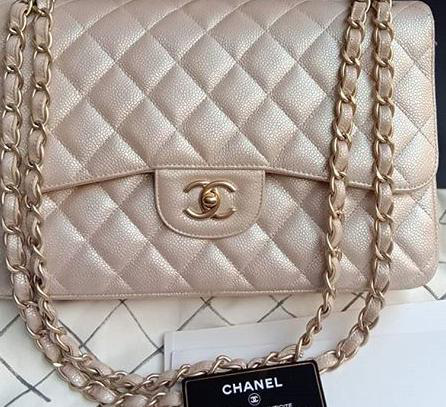

In [62]:
datasets.ImageFolder(os.path.join(data_dir, "test"))[0][0]

In [25]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
len(class_names)

19

In [8]:
class_names

['2.55_classicdoubleflapbag',
 'F57842',
 'alma',
 'bag',
 'boy',
 'classic',
 'dionysus',
 'ggmarmont',
 'grandshoppingtote',
 'jetsettote',
 'mercertotebag',
 'neverfull',
 'newwavechaintote',
 'other',
 'petiteboitechapeau',
 'selmasatchel',
 'sohodisco',
 'speedy',
 'sylvie']

In [1]:
def imshow(inp, title=None, save=False, index=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #if save:
    #    plt.imsave('graphs/' + str(index) + '_05.png', inp)
        
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    return inp

In [13]:
test = iter(testloaders['test'])

In [14]:
inputs, classes = next(test)

In [15]:
out = torchvision.utils.make_grid(inputs)

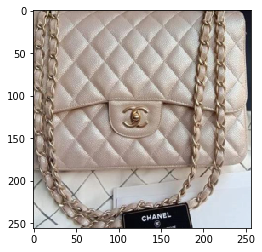

In [16]:
imshow(out)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(running_corrects)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 19)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

### Evaluate Model Performance

In [2]:
def visualize_model(model, num_images=6, save=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(8,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, target:{}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


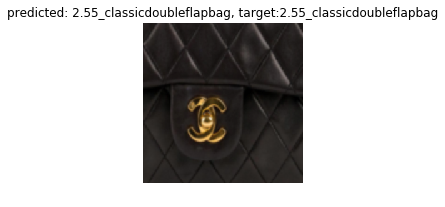

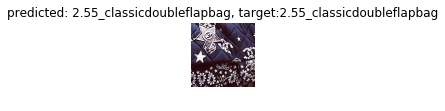

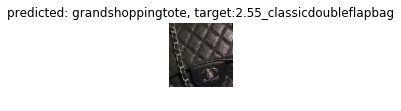

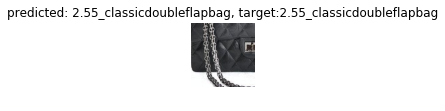

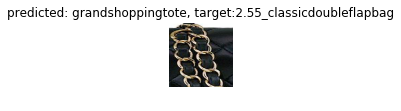

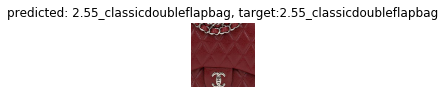

In [63]:
visualize_model(model_ft)

In [127]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=[14,12])
    #plt.ylim(ymin=-0.5, ymax=18.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
    ax.set_ylabel(ylabel='True label', fontsize=16)
    ax.set_xlabel(xlabel='Predicted label', fontsize=16)
    ax.set_title(label=title, fontsize=16)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    #plt.ylim(ymin=-0.5, ymax=18.5)
    #plt.xlim([-0.5,18.5])
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12,);

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", size=10, color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout(pad=0.0001);
    
    return ax

In [14]:
model_name = torch.load("../models/model_name_resnet50gpu_correct_merged", map_location=torch.device('cpu'))
model_ft.load_state_dict(model_name)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
pred_list = []
label_list = []
for i, (inputs, labels) in enumerate(testloaders['test']):
    print(i)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list.extend(preds.numpy())
    label_list.extend(labels.numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
out = open("model_name_predict.csv", "w")
out.write("target,predict\n")
for idx, i in enumerate(label_list):
    out.write(str(i) + "," + str(pred_list[idx]) + "\n")
out.close()

In [26]:
data = pd.read_csv("model_name_predict.csv")
data.head(30)
label_list = data["target"]
pred_list = data["predict"]

,target,predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [35]:
### Change current class_names, make it shorter
class_names[0] = "2.55"
class_names[3] = "handbag"
class_names[13] = "None"

In [39]:
new_class_names = ["2.55", "boy", "grandshoppingtote",
                  "alma", "neverfull", "speedy", "petiteboitechapeau", "newwavechaintote",
                  "jetsettote", "selmasatchel", "mercertotebag",
                  "dionysus", "sohodisco", "ggmarmont","sylvie",
                  "F57842",
                  "classic",
                  "handbag",
                  "None"]

In [42]:
def get_index(class_name, new_class_name):
    index_map = []
    for idx, i in enumerate(class_name):
        new_idx = new_class_name.index(i)
        index_map.append([idx, new_idx])
    
    return index_map

In [45]:
### Reorder the class based on brands
index_map = get_index(class_names, new_class_names)

In [123]:
def convert_name(pre_list, index_map):
    new_list = []
    for j in pre_list:
        new_list.append([i[1] for i in index_map if int(i[0]) == j][0])
    return new_list

In [124]:
new_label_list = convert_name(label_list, index_map)
new_predict_list = convert_name(pred_list, index_map)

#### Get confusion matrix

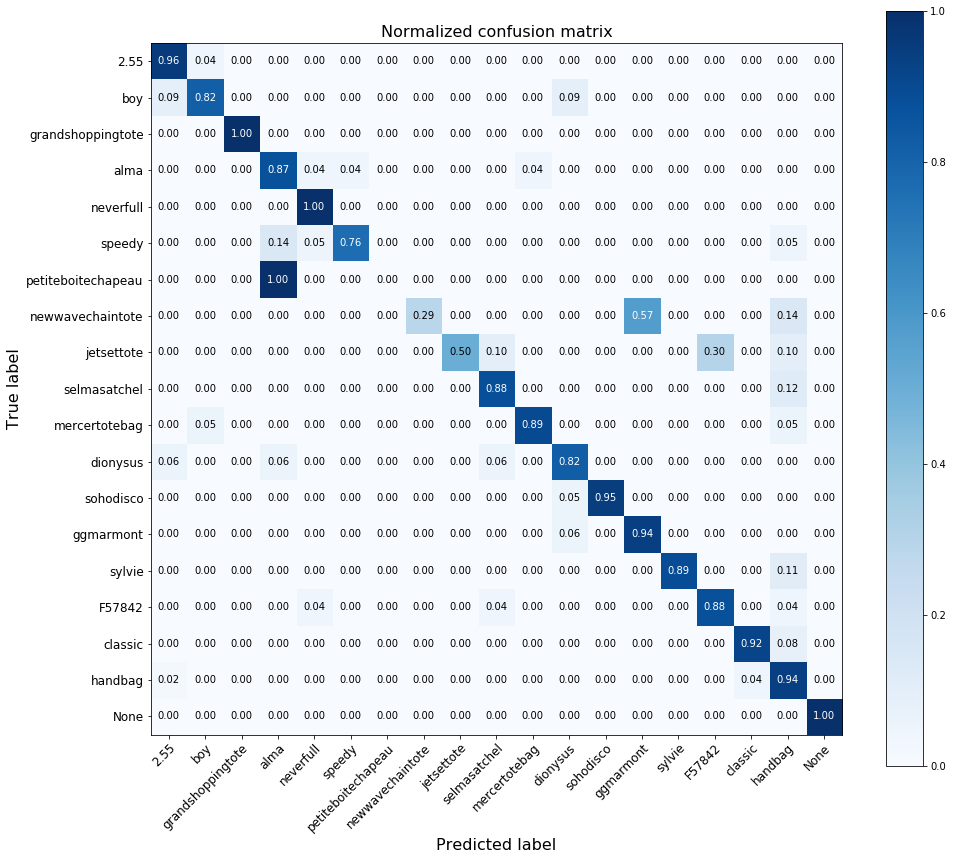

In [133]:
### Get confusion matrix
fig = plot_confusion_matrix(new_label_list,new_predict_list, classes=new_class_names, normalize=True, title=None,cmap=plt.cm.Blues)
plt.savefig("../demo/model_confusion_maxtrix.pdf", dpi = 300);

#### Get Accuracy

In [136]:
num = 0 
for i in range(len(new_predict_list)):
    if new_predict_list[i] == new_label_list[i]:
        num += 1
num/len(new_predict_list)

0.8964646464646465

#### Get F1_score

In [140]:
f1_score(new_label_list, new_predict_list, average="weighted")

/Users/jianinglu1/anaconda3/envs/datainsight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8901768889432261

#### Check crop size effect on accuracy

To answer the question, how large portion is needed for my model to do the preditcion? I checked the performance of my model with different crop percentage.

In [6]:
def get_accuracy(testloaders):
    pred_list = []
    label_list = []
    for i, (inputs, labels) in enumerate(testloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        pred_list.extend(preds.numpy())
        label_list.extend(labels.numpy())
        if i % 100 == 0:
            print(i)
    acc = len([1 for i in range(399) if pred_list[i] == label_list[i]]) / 399 
    f1 = f1_score(label_list, pred_list, average="weighted")
    return acc, f1
    

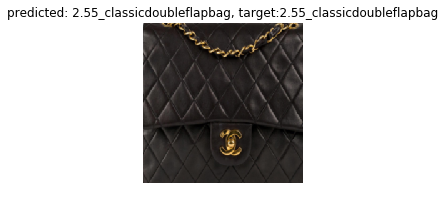

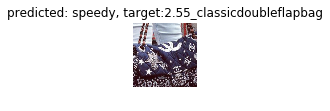

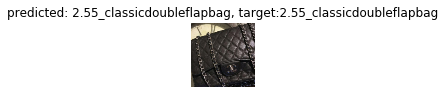

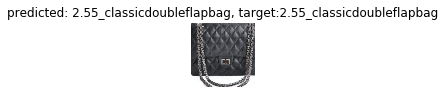

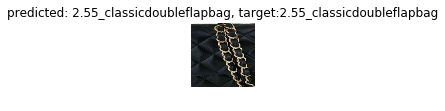

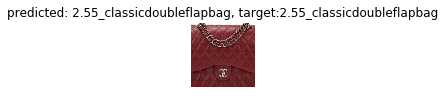

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.88, accuracy is 0.89, f1 score is 0.88


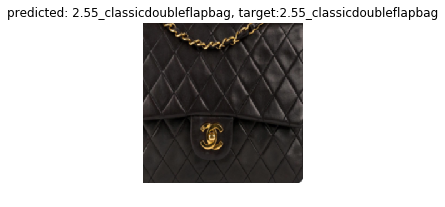

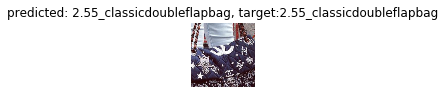

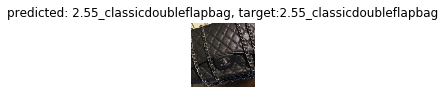

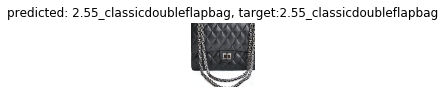

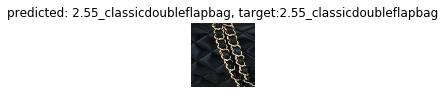

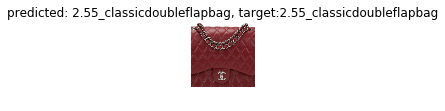

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.86, accuracy is 0.88, f1 score is 0.87


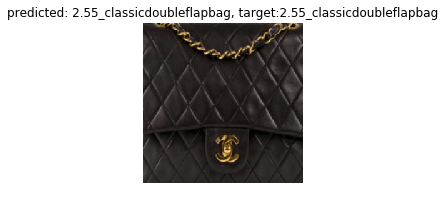

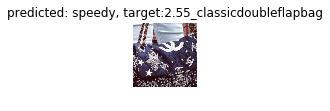

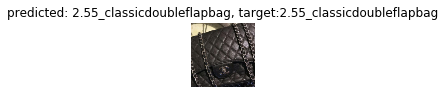

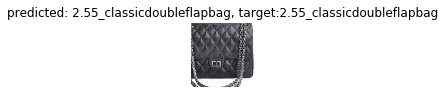

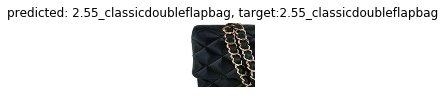

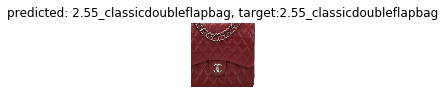

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.83, accuracy is 0.86, f1 score is 0.85


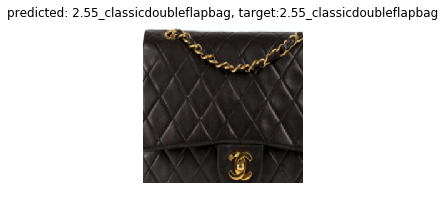

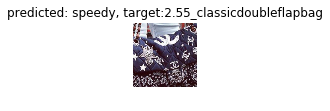

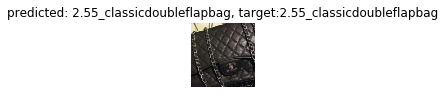

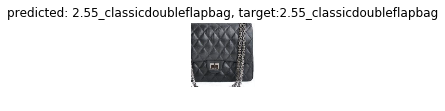

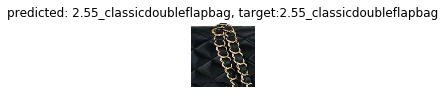

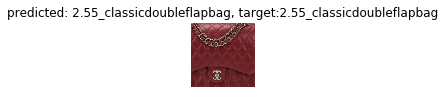

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.80, accuracy is 0.86, f1 score is 0.85


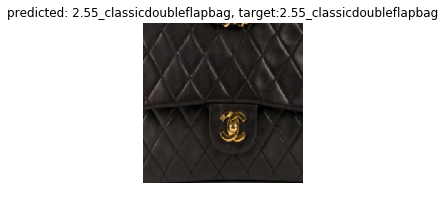

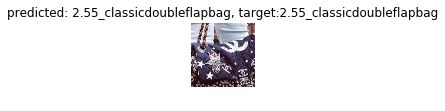

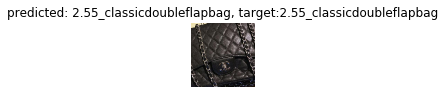

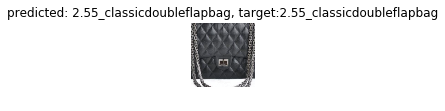

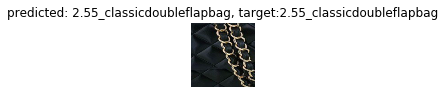

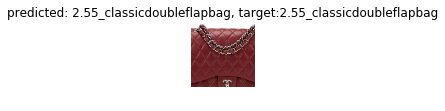

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.75, accuracy is 0.86, f1 score is 0.85


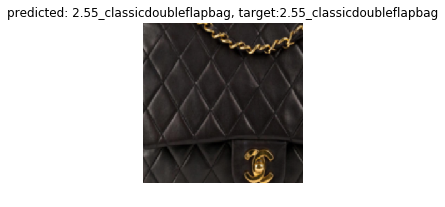

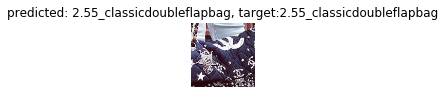

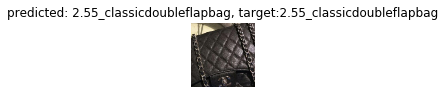

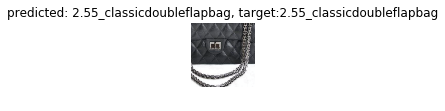

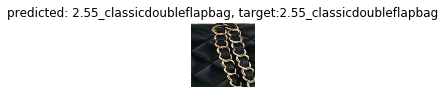

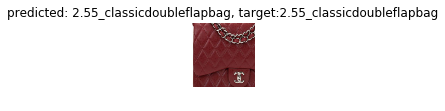

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.67, accuracy is 0.82, f1 score is 0.81


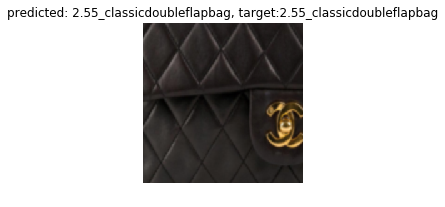

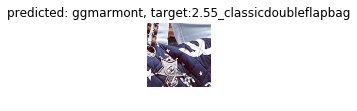

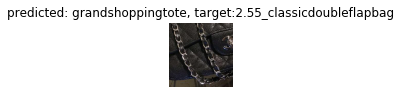

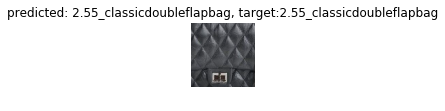

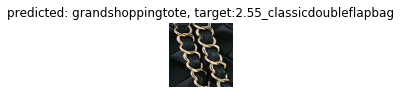

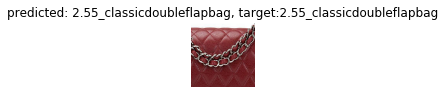

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.50, accuracy is 0.72, f1 score is 0.71


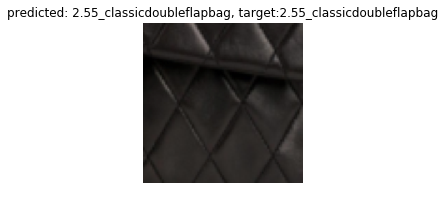

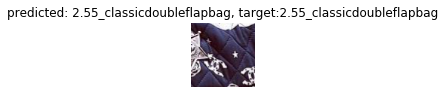

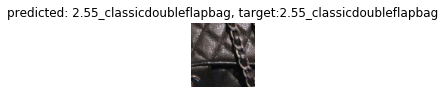

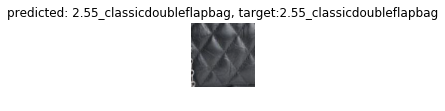

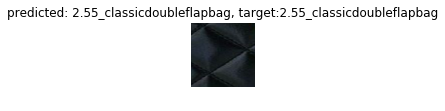

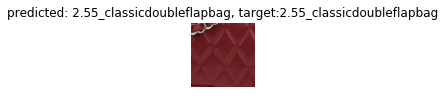

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.33, accuracy is 0.49, f1 score is 0.49


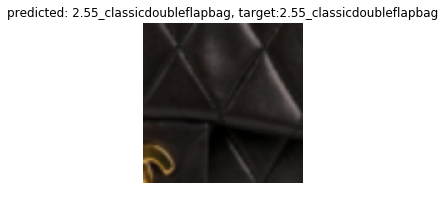

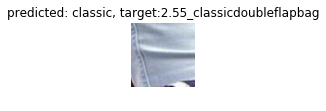

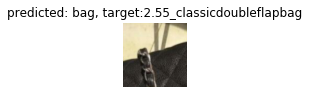

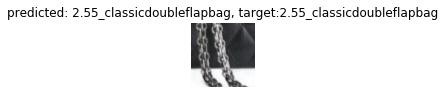

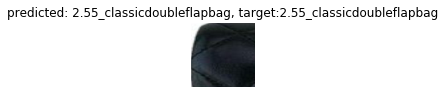

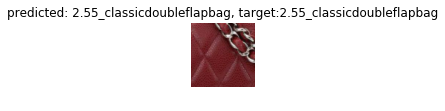

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.25, accuracy is 0.35, f1 score is 0.35


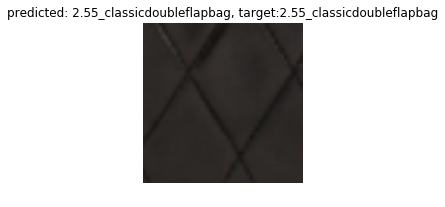

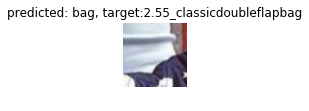

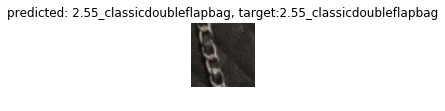

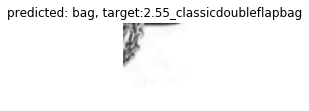

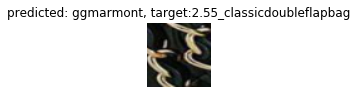

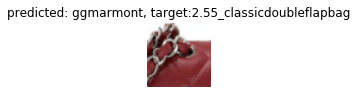

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.20, accuracy is 0.27, f1 score is 0.24


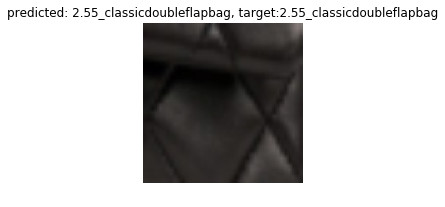

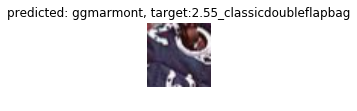

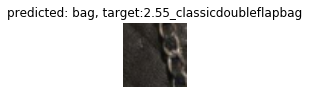

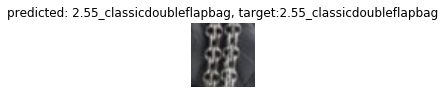

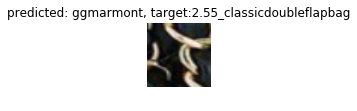

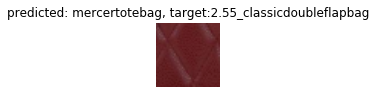

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.17, accuracy is 0.20, f1 score is 0.17


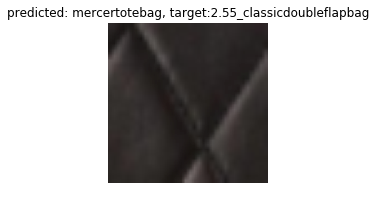

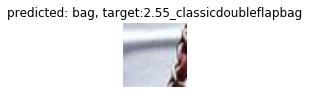

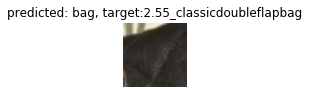

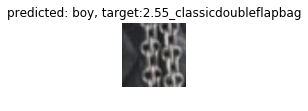

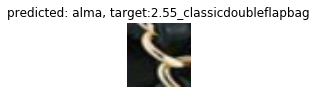

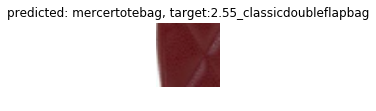

0
100
200
300


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


keep ratio is 0.14, accuracy is 0.15, f1 score is 0.11


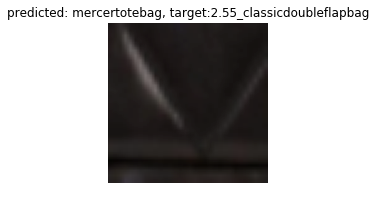

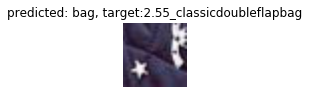

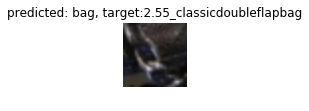

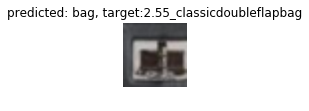

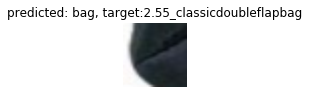

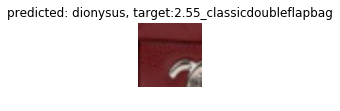

0
100
200
300
keep ratio is 0.12, accuracy is 0.13, f1 score is 0.07


/Users/jianinglu1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
acc_list = []
f1_list = []
for i in [7/8,6/7,5/6, 4/5, 3/4, 2/3, 1/2, 1/3, 1/4, 1/5, 1/6,1/7,1/8]:
    data_transforms = {
        'val': transforms.Compose([
            transforms.Resize((256,256)),
            transforms.RandomCrop((int(256 * i) ,int(256 * i) )),
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((256,256)),
            transforms.RandomCrop((int(256 * i) ,int(256 * i) )),
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['val', 'test']}
    testloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False)
                for x in [ 'val', 'test']}
    visualize_model(model_ft)
    acc, f1 = get_accuracy(testloaders)
    acc_list.append(acc)
    f1_list.append(f1)
    print("keep ratio is {:.2f}, accuracy is {:.2f}, f1 score is {:.2f}".format(i, acc, f1))
    

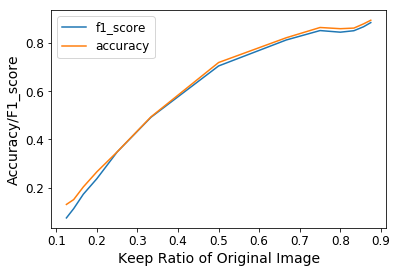

In [101]:
fig = plt.figure(figsize=[6,4])
plt.plot([7/8,6/7,5/6, 4/5, 3/4, 2/3, 1/2, 1/3, 1/4, 1/5, 1/6,1/7,1/8], f1_list, label="f1_score")
plt.plot([7/8,6/7,5/6, 4/5, 3/4, 2/3, 1/2, 1/3, 1/4, 1/5, 1/6,1/7,1/8], acc_list, label="accuracy")
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Keep Ratio of Original Image", size=14)
plt.ylabel("Accuracy/F1_score", size=14)
plt.legend(fontsize=12)
plt.savefig("graphs/Performance_Diff_CropSize.png", dpi=100);

When using 25% of image as input, my model can still achieve **0.71 f1_score** and **0.72 accuracy** on test set!